# Automatic differentiation with `autograd`
Prior to `v0.4` PyTorch used the class `Variable` to record gradients. You had to wrap `Tensor`s in `Variable`s.
`Variable`s behaved exactly like `Tensors`.

With `v0.4` `Tensor` can record gradients directly if you tell it do do so, e.g. `torch.ones(3., requires_grad=True)`.
There is no need for `Variable` anymore.
Many tutorials still use `Variable`, be aware!

Simply add `requires_grad=True` to the tensors you want to calculate the gradients for. PyTorch libraries such as `nn.Module` track gradients automatically.

## Autograd is disabled by default

In [1]:
import torch as pt

In [2]:
x = pt.tensor(2.)
x

tensor(2.)

In [3]:
y = pt.tensor(3.)
y

tensor(3.)

In [4]:
z = x + y

In [5]:
x.requires_grad, y.requires_grad, z.requires_grad,

(False, False, False)

### `backward()` is equivalent to `backward(tensor(1.0))`

In [6]:
z.requires_grad = True

z.backward(pt.tensor(1.0)) 

z.grad, x.grad, y.grad

(tensor(1.), None, None)

In [7]:
z.is_leaf

True

## Enable autograd for a tensor with `requires_grad = True`

In [8]:
x = pt.tensor(2., requires_grad=True)
x

tensor(2., requires_grad=True)

In [9]:
x.requires_grad

True

In [10]:
print(x.grad)

None


## Non-leaf tensors acquire autograd by default

In [12]:
x = pt.tensor(2., requires_grad=True)
y = pt.tensor(3.)

#the product of x and z is a non-leaf tensor
x * y

x.requires_grad, y.requires_grad

(True, False)

In [13]:
y = x ** 2

y.requires_grad, y.grad_fn

(True, <PowBackward0 at 0x7fa05f8c9150>)

In [17]:
y = x ** 2
y.grad = pt.tensor(1.0)
y.backward()

x.grad, y.grad

(tensor(12.), tensor(1.))

## Ignore autograd with `no_grad()`; useful for inference

In [18]:
x = pt.tensor(2., requires_grad=True)

with pt.no_grad():
    y = x * x
    print(y.grad_fn)

None


In [19]:
y.backward()

RuntimeError: ignored

In [20]:
from torch import nn

In [25]:
model = nn.Linear(1, 1)
model.bias.data

tensor([-0.2761])

<html><h2><font style="color:red">GPU support is required</font> to demonstrate high performance tensor operations</h2></html>

In [27]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('In Google Colab select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

device = pt.device("cuda" if pt.cuda.is_available() else "cpu")
print('using device:', device)  

Tue Jan 25 00:42:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

When CUDA drivers are installed on the device, the following returns the CUDA capability profile documented by nVidia. For the capability profile v6.0 check out https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#compute-capability-6-x for information about the capability profile include the expected count of the Arithmetic Logic Units (ALUs).


In [28]:
pt.cuda.get_device_capability(device) if pt.cuda.is_available() else None

(6, 0)

## PyTorch tensor operations require tensors to reside on the same device 
* Use the `to` function to transfer a tensor to a specific device

In [29]:
a = pt.ones(100).to("cpu")
b = pt.ones(100).to("cuda")
a + b

RuntimeError: ignored

In [30]:
import timeit

MAX_SIZE = 28
sizes = [2 ** i for i in range(MAX_SIZE)]

def benchmark_cpu_gpu(n):
  for device in ["cpu", "cuda"]:
    for size in sizes:
      a = pt.randn(size).to(device)
      b = pt.randn(size).to(device)
      yield timeit.timeit(lambda: a + b, number = n)

measurements = list(benchmark_cpu_gpu(1))

## Measure the performance ratio CPU / GPU, higher is faster GPU

In [31]:
cpu = measurements[:MAX_SIZE]
gpu = measurements[MAX_SIZE:]
ratios = [cpu[i] / gpu[i] for i in range(len(cpu))]
ratios

[0.01343199443485354,
 0.3390831188459771,
 0.4553056997676515,
 0.3480599207817182,
 0.27132053943818074,
 0.30256192137877025,
 0.16177202913487349,
 0.37901069835696377,
 0.33108156490220747,
 0.32590063882955495,
 0.7347933437583076,
 0.4460057877507823,
 0.6618728996071774,
 0.2875296471850908,
 0.9239267285657555,
 2.323639027287085,
 2.7459708636166917,
 5.516338511163593,
 6.426358738487539,
 8.994388490567685,
 19.891535011822153,
 5.8843556672212065,
 110.4969387379891,
 26.38132343729065,
 96.68982531746796,
 86.30662285178698,
 244.00046090690327,
 203.39010170462916]

## When adding tensors with `16,384` values and more, GPU can be `150x` faster

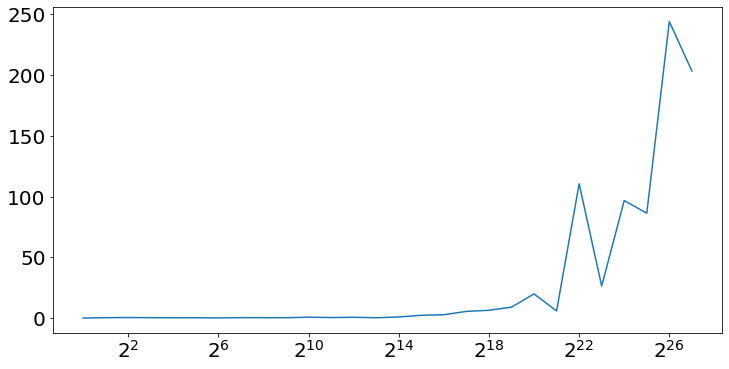

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.figure(figsize=(12,6))
plt.plot(sizes, ratios)
plt.xscale("log", basex=2)

## GPU performance on tensors with `8,192`  or fewer elements is on par with CPUs

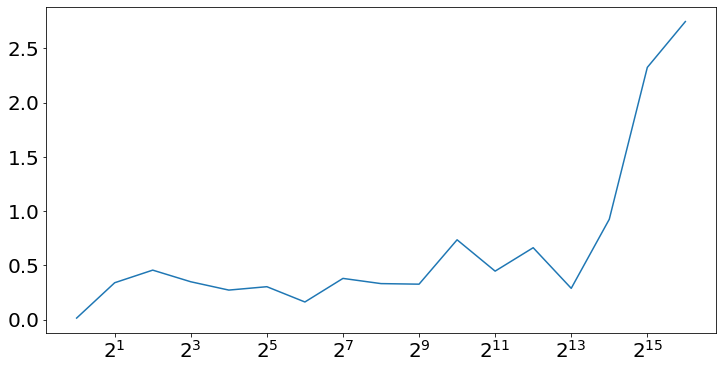

In [33]:
plt.figure(figsize=(12,6))

plt.plot(sizes[:17], ratios[:17])
plt.xscale("log", basex=2);

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

Copyright 2021 CounterFactual.AI LLC. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.